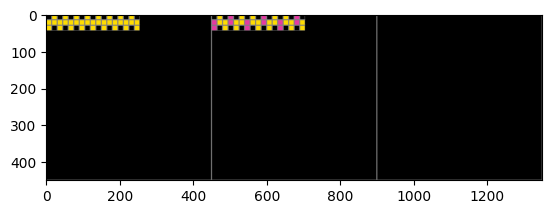

ba26e723 tensor(0.3349, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from arc_ahrm import ArcAHRM
from load_dataset import LoadDataset
from custom_functions import CustomFunctions
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from IPython.display import clear_output
from visualization import Visualization


if __name__ == "__main__":

    torch.autograd.set_detect_anomaly(True)
    print(torch.__version__, torch.cuda.is_available())

    #script_directory = os.path.dirname(os.path.realpath(__file__))
    script_directory = os.getcwd()
    
    tasks = {}
    tasks_ = {}
    tasks_.update(LoadDataset.load_arc_tasks(script_directory + "/ARC-AGI/data/training"))

    for _ in range(1):
        augmented = LoadDataset.augment(tasks_)
        tasks.update(augmented)

    tasks_.update(LoadDataset.load_arc_tasks(script_directory + "/ARC-AGI/data/evaluation"))
    tasks_.update(LoadDataset.load_arc_tasks(script_directory + "/ARC-AGI-2/data/training"))
    tasks_.update(LoadDataset.load_arc_tasks(script_directory + "/ARC-AGI-2/data/evaluation"))
    tasks.update(tasks_)

    keys = list(tasks.keys())
    random.shuffle(keys)
    tasks = {key: tasks[key] for key in keys}

    batchable_tasks =  LoadDataset.tasks_to_batchable(tasks)

    #d_model = 128
    d_model = 512
    #d_model = 512 + 128 + 64
    print("d_model:", d_model)
    
    arc_ahrm = ArcAHRM(d_model).to("cuda")
    #arc_ahrm.load_state_dict(torch.load(script_directory + "/saved/arc_ahrm.pt"))
    optimizer = torch.optim.Adam(arc_ahrm.parameters(), lr=1e-4)

    total_params = sum(p.numel() for p in arc_ahrm.parameters())
    print(f"Total parameters: {total_params}")

    test_input = batchable_tasks["test"][:, 0]
    test_output = batchable_tasks["test"][:, 1]

    max_iterations = 13
    batch_size = 31
    y = None

    epoch_losses = []
    for i_epoch in range(100):
        done_amount = 0

        epoch_loss = 0
        while done_amount < len(batchable_tasks["train"]):

            if batch_size == 0:
                break

            while True:
                try:
                    print(i_epoch, "epoch", done_amount, "done from", len(batchable_tasks["train"]))
                    clear_output(wait=True)
                    current_batch_size = min(batch_size, len(batchable_tasks["train"]) - done_amount)
                    end = done_amount + current_batch_size
                    
                    for inner_epoch in range(1):
                        for i in range(max_iterations):
                            
                            if i < max_iterations - 1:
                                with torch.no_grad():
                                    y = arc_ahrm(batchable_tasks["train"][done_amount:end], test_input[done_amount:end])
                                continue
                            else:
                                y = arc_ahrm(batchable_tasks["train"][done_amount:end], test_input[done_amount:end])
                            
                            target = test_output[done_amount:end].to(torch.long)
                            
                            prediction = torch.argmax(F.softmax(y, dim=-1), dim=-1)
                            
                            
                            images = []
                            images.append(Visualization.draw_grid(test_input[done_amount]))
                            images.append(Visualization.draw_grid(target[0]))
                            images.append(Visualization.draw_grid(prediction[0]))

                            horizontal_concat = cv2.hconcat(images)
                            #cv2.destroyAllWindows()
                            #cv2.imshow('input-target-prediction', horizontal_concat)
                            plt.imshow(cv2.cvtColor(horizontal_concat, cv2.COLOR_BGR2RGB))
                            plt.show()

                            #cv2.waitKey(1)
                            
                            if i < max_iterations - 1:
                                continue

                            loss = F.cross_entropy(
                                y.permute(0, 3, 1, 2),
                                target.to(torch.long)
                            )

                            epoch_loss += loss.item()

                            print(loss, torch.cuda.memory_allocated() / 1024 / 1024)

                            base_lr = 1e-3

                            optimizer.zero_grad()
                            loss.backward()
                            optimizer.step()

                        arc_ahrm.ahrm.reset()

                    #clear_output(wait=True)
                    done_amount += current_batch_size
                    break
                except torch.cuda.OutOfMemoryError:
                    arc_ahrm.ahrm.reset()
                    batch_size //= 2
                    #batch_size = max(batch_size, 1)
                    print(batch_size, "batch_size")
                    if batch_size == 0:
                        break

        epoch_losses.append(epoch_loss / len(test_input))
            
    #y = F.softmax(y, dim=-1)

    #prediction = torch.argmax(y, dim=-1)

    #print(prediction.shape)
    #print(prediction[0])
    #print(arc_ahrm.ahrm.pattern_reader)
    
    if batch_size != 0:
        torch.save(arc_ahrm.state_dict(), script_directory + "/saved/arc_ahrm.pt")
        with open(script_directory + '/saved/epoch_losses', 'w') as f:
            json.dump(epoch_losses, f)
    else:
        print("batch_size has become 0")